In [87]:
import pandas as pd
import numpy as np

# For data preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# For the neural network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# For evaluation
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

import seaborn as sns

In [88]:
# Cargar los datos
df = pd.read_csv("./input/Factors_ affecting_ university_student_grades_dataset.csv")

# Preview the first few rows
df.head()

,Age,Gender,Parental_Education,Family_Income,Previous_Grades,Attendance,Class_Participation,Study_Hours,Major,School_Type,...,Peer_Group,Bullying,Study_Space,Learning_Style,Tutoring,Mentoring,Lack_of_Interest,Time_Wasted_on_Social_Media,Sports_Participation,Grades
0,22.0,F,College,50000.0,A,81.0,Medium,8.0,Law,Private,...,Neutral,NaN,No,Visual,Yes,NaN,Low,2.0,NaN,B
1,21.0,M,NaN,60000.0,A,NaN,Medium,12.0,Law,Public,...,Negative,No,No,Auditory,Yes,Yes,Medium,5.0,High,NaN
2,19.0,M,College,75000.0,C,93.0,Medium,12.0,Law,Private,...,Neutral,No,Yes,NaN,No,No,Low,2.0,High,A
3,21.0,M,College,60000.0,A,86.0,Low,15.0,Business,Public,...,Neutral,No,NaN,Auditory,Yes,Yes,Low,3.0,Medium,C
4,19.0,NaN,NaN,40000.0,NaN,89.0,High,15.0,Medicine,NaN,...,Positive,No,No,Auditory,Yes,NaN,Medium,3.0,High,B


In [89]:
# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=['float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Convert specific object columns to numerical if they are actually numerical
df['Family_Income'] = pd.to_numeric(df['Family_Income'], errors='coerce')

# Re-identify numerical and categorical columns after conversion
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Fill missing values in numerical columns with the mean
for col in numerical_cols:
    df[col].fillna(df[col].mean(), inplace=True)

# Fill missing values in categorical columns with the mode
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)


C:\Users\brand\AppData\Local\Temp\ipykernel_11772\2739803760.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
C:\Users\brand\AppData\Local\Temp\ipykernel_11772\2739803760.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

In [90]:
# Encode the target variable 'Grades'
label_encoder = LabelEncoder()
df['Grades'] = label_encoder.fit_transform(df['Grades'])

# One-hot encode the remaining categorical variables
categorical_cols = categorical_cols.drop('Grades')
df = pd.get_dummies(df, columns=categorical_cols)

df.to_csv('output/encoded_data.csv', index=False)



In [91]:
# Define X (features) and y (target)
X = df.drop('Grades', axis=1)
y = df['Grades']

X.to_csv('output/features_data.csv', index=False)
y.to_csv('output/target_data.csv', index=False)

In [92]:
# Check the distribution of classes
unique, counts = np.unique(y, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class Distribution:", class_distribution)


Class Distribution: {np.int64(0): np.int64(2976), np.int64(1): np.int64(4078), np.int64(2): np.int64(3010)}


In [93]:
# Print the column names to identify the correct names after one-hot encoding
print(X.columns)

# Select the top features based on the correct column names
X_top_features = X[['Time_Wasted_on_Social_Media', 'Screen_Time', 'Age', 
					'Bullying_Yes', 'Educational_Resources_Yes', 
					'Parental_Involvement_High', 'School_Type_Public', 
					'Gender_M', 'Extracurricular_Activities_Yes']]

Index(['Age', 'Family_Income', 'Attendance', 'Study_Hours', 'Class_Size',
       'Sleep_Patterns', 'Screen_Time', 'Time_Wasted_on_Social_Media',
       'Gender_F', 'Gender_M', 'Parental_Education_College',
       'Parental_Education_Graduate', 'Parental_Education_High School',
       'Parental_Education_Some College', 'Previous_Grades_A',
       'Previous_Grades_B', 'Previous_Grades_C', 'Class_Participation_High',
       'Class_Participation_Low', 'Class_Participation_Medium', 'Major_Arts',
       'Major_Business', 'Major_Engineering', 'Major_Law', 'Major_Medicine',
       'Major_Science', 'School_Type_Private', 'School_Type_Public',
       'Financial_Status_High', 'Financial_Status_Low',
       'Financial_Status_Medium', 'Parental_Involvement_High',
       'Parental_Involvement_Low', 'Parental_Involvement_Medium',
       'Educational_Resources_No', 'Educational_Resources_Yes',
       'Motivation_High', 'Motivation_Low', 'Motivation_Medium',
       'Self_Esteem_High', 'Self_Esteem_Low'

In [94]:
# Scale the features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X_top_features)
 
# X_scaled_df = pd.DataFrame(X_scaled, columns=X_top_features.columns)
# X_scaled_df.to_csv('output/scaled_data.csv', index=False)


from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X_top_features)

X_normalized_df = pd.DataFrame(X_normalized, columns=X_top_features.columns)
X_normalized_df.to_csv('output/normalized_data.csv', index=False)


In [95]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y, test_size=0.20, random_state=42
)

# Convert numpy arrays to DataFrames or Series
X_train_df = pd.DataFrame(X_train, columns=X_top_features.columns)
X_test_df = pd.DataFrame(X_test, columns=X_top_features.columns)
y_train_series = pd.Series(y_train)
y_test_series = pd.Series(y_test)

#print shapes
print(X_train_df.shape)
print(y_train_series.shape)
print(X_test_df.shape)
print(y_test_series.shape)

# to csv
X_train_df.to_csv('output/X_train.csv', index=True)
X_test_df.to_csv('output/X_test.csv', index=True)
y_train_series.to_csv('output/y_train.csv', index=True)
y_test_series.to_csv('output/y_test.csv', index=True)

(8051, 9)
(8051,)
(2013, 9)
(2013,)


In [96]:
# Convert labels to categorical one-hot encoding
num_classes = len(np.unique(y))
print(f'Number of classes: {num_classes}')

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)


Number of classes: 3


In [ ]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

def create_model(learning_rate=0.001, dropout_rate=0.3, neurons=64):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(int(neurons/2), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, verbose=0)
param_grid = {
    'learning_rate': [0.001, 0.0001],
    'dropout_rate': [0.3, 0.2],
    'neurons': [64, 128],
    'batch_size': [32, 64],
    'epochs': [100, 200]
}
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)
print(f"Mejor Precisión: {grid_result.best_score_} usando {grid_result.best_params_}")


# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

checkpoint = ModelCheckpoint(
    filepath="best_model.keras",  # Use .keras extension for the saved model
    save_best_only=True,
    monitor="val_loss",
    mode="min",
)

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


ModuleNotFoundError: No module named 'tensorflow.keras.wrappers'

In [ ]:
optimizer = Adam(learning_rate=0.001)  # Try a smaller learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model with early stopping
history = model.fit(
    X_train, y_train, epochs=200, batch_size=32, validation_split=0.1, callbacks=[early_stop, checkpoint]
)


Epoch 1/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.3419 - loss: 1.4639 - val_accuracy: 0.3983 - val_loss: 1.1981
Epoch 2/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3548 - loss: 1.2544 - val_accuracy: 0.3983 - val_loss: 1.1864
Epoch 3/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3781 - loss: 1.2119 - val_accuracy: 0.3859 - val_loss: 1.1838
Epoch 4/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3719 - loss: 1.1864 - val_accuracy: 0.3883 - val_loss: 1.1825
Epoch 5/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3944 - loss: 1.1745 - val_accuracy: 0.3859 - val_loss: 1.1740
Epoch 6/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4001 - loss: 1.1617 - val_accuracy: 0.3784 - val_loss: 1.1697
Epoch 7/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4002 - loss: 1.1553 - val_accuracy: 0.3883 - val_loss: 1.1599
Epoch 8/200
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4055 - loss: 1.1476 - val_accu

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.3741


In [ ]:
# Predict on test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate classification report
print(classification_report(y_true_classes, y_pred_classes))


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.28      0.08      0.12       583
           1       0.39      0.87      0.54       788
           2       0.24      0.04      0.06       642

    accuracy                           0.37      2013
   macro avg       0.30      0.33      0.24      2013
weighted avg       0.31      0.37      0.27      2013



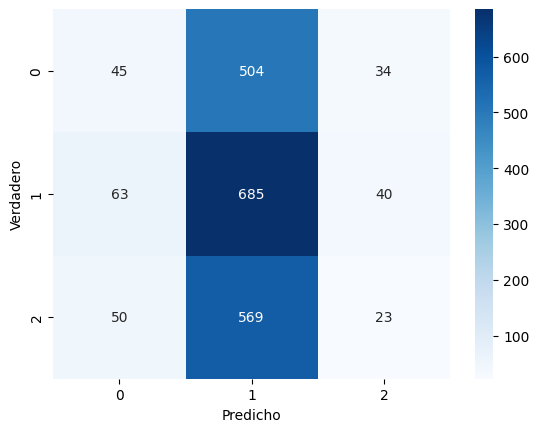

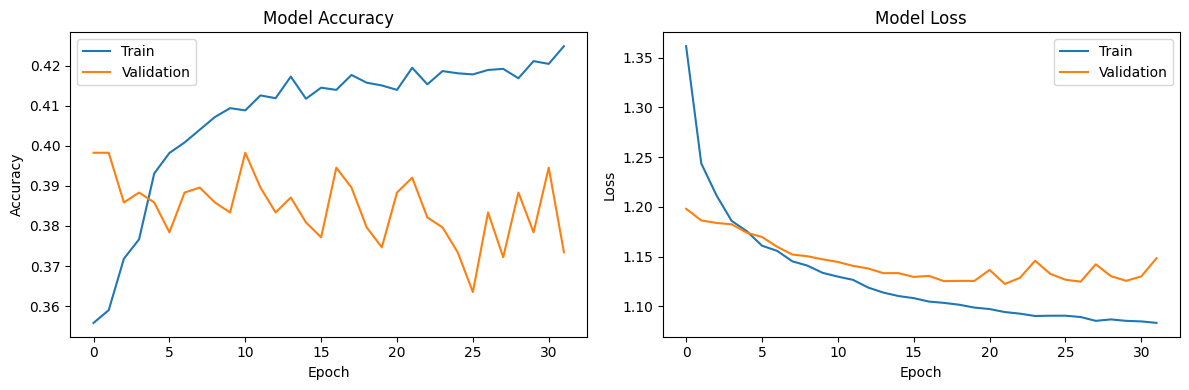

In [ ]:
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
